# 02. Neural Network classification with pytorch

Classification is a problem of predicting whether something is one thing or another

## 1. Make classificaton datat an get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: \n {X[:5]}")
print(f"First 5 samples of y: \n {y[:5]}")

First 5 samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
 [1 1 1 1 0]


In [5]:
# Make Datatframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


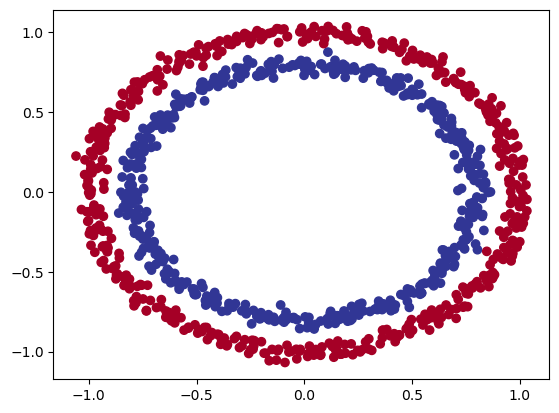

In [6]:
# Visualise 
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to toy dataset

### 1.1 Check input and output

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same y: {y_sample}")
print(f"Shapess for one sample of X: {X_sample.shape} and the same y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same y: 1
Shapess for one sample of X: (2,) and the same y: ()


### 1.2 turn data into tensors and creat train and test splits

In [9]:
import torch
torch.__version__

'2.2.2'

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
torch.manual_seed(42)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(X, 
                                                  y,
                                                  test_size=0.2, #20% test and 80% train split
                                                  random_state=42)

In [14]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we wnat to:
1. Setup device agonistic code so our code wil run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
# Import pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available else "cpu"
device

'cuda'

In [16]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup model agnostic code, let's create a model that:

1. Subclsses `nn.Module` (almost all modesl in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model clasa and send it to the target device

In [17]:
from sklearn import datasets
# 1. Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
   def __init__(self):
      super().__init__()
      # 2. Create 2 nn.Linear() layers capable of handling the shapes of our data
      self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales to 5 features
      self.layer_2 = nn.Linear(in_features=5, out_features=1) # Teaks in 5 features from previous layer and output 1 feature

      #3. Define a forward() method that outlines the forward pass
      def forward(self, x):
         return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
      
#4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
   nn.Linear(in_features=2,out_features=5),
   nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [21]:
# Make predictions
with torch.inference_mode():
   untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

+ Regresssion - MAE or MSE (mean absolute or mean square error)
+ Classificaiton - Binary cross entropy or Categorical cross entropy (cross entropy)

Loss function measure how *wrong* your models are.

Optimizers:

+ Most common at SGD and Adam (Stochastic Gradient Descent)

In [22]:
# Setup Loss Function
loss_fn = nn.BCEWithLogitsLoss() # BCE with sigmoid activation function builtin

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# Calculate accuracy - What percentage does the model get the prediction right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc



## 3. Train Model

1. Forward pass
2. Calculate the loss
3. Optimize Zero Grad
4. Loss backward (back propagation)
5. Optimizer step (Gradient Descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Model output is raw **logits**

We can convert **logits** to **prediction probabilities** by passing through an activation function.

Then we can convert the **prediction probabilities** to labels by rounding or using the `argmax` function 




In [24]:
# View the first 5 outputs of the test_data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits


tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# Use sigmoid activation function on model logits to change them to prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [27]:
# Find the predicted labels of the model
y_preds = torch.round(y_pred_probs)

# In Full (logits -> pred probs  -> pred labels)
y_preds_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))


# Check for equality
print(torch.eq(y_preds.squeeze(),y_preds_label.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [28]:
torch.manual_seed(42)
if device == "mps":
    torch.mps.manual_seed(42)
elif device == "cuda":
    torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_test, y_test = X_test.to(device), y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

# Build trianing and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

    # 2. Calculate the loss function
    loss_bce = loss_fn(
        torch.sigmoid(y_train),  # nn.BCELoss expects predicticion probilities as input
        y_pred,
    )
    loss_bcelogits = loss_fn(y_logits, ## nn.BCEwithLogitsLoss expects raw logits as input
                             y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer grad zero
    optimizer.zero_grad()

    # 4. Loss backward (back propagation)
    loss_bcelogits.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what is happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_bcelogits:.5f} | Acc: {acc:.2f} % | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f} %")


Epoch: 0 | Loss: 0.69796 | Acc: 51.88 % | Test Loss: 0.69440 | Test Acc: 58.00 %
Epoch: 10 | Loss: 0.69590 | Acc: 51.25 % | Test Loss: 0.69305 | Test Acc: 53.00 %
Epoch: 20 | Loss: 0.69490 | Acc: 51.62 % | Test Loss: 0.69254 | Test Acc: 49.50 %
Epoch: 30 | Loss: 0.69435 | Acc: 51.12 % | Test Loss: 0.69236 | Test Acc: 49.50 %
Epoch: 40 | Loss: 0.69401 | Acc: 50.88 % | Test Loss: 0.69232 | Test Acc: 51.00 %
Epoch: 50 | Loss: 0.69378 | Acc: 50.25 % | Test Loss: 0.69234 | Test Acc: 50.00 %
Epoch: 60 | Loss: 0.69362 | Acc: 50.00 % | Test Loss: 0.69239 | Test Acc: 51.50 %
Epoch: 70 | Loss: 0.69351 | Acc: 50.25 % | Test Loss: 0.69246 | Test Acc: 51.00 %
Epoch: 80 | Loss: 0.69342 | Acc: 49.88 % | Test Loss: 0.69254 | Test Acc: 50.00 %
Epoch: 90 | Loss: 0.69336 | Acc: 49.88 % | Test Loss: 0.69262 | Test Acc: 53.00 %


## 4. Make prediction and evaluate the model

Model is not learning anything



In [29]:
import requests
from pathlib import Path

# Download helper function file if it is not downloaded
if Path("helper_functions.py").is_file():
    print("Helper function file already exist")
else:
    print("download helper function")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Helper function file already exist


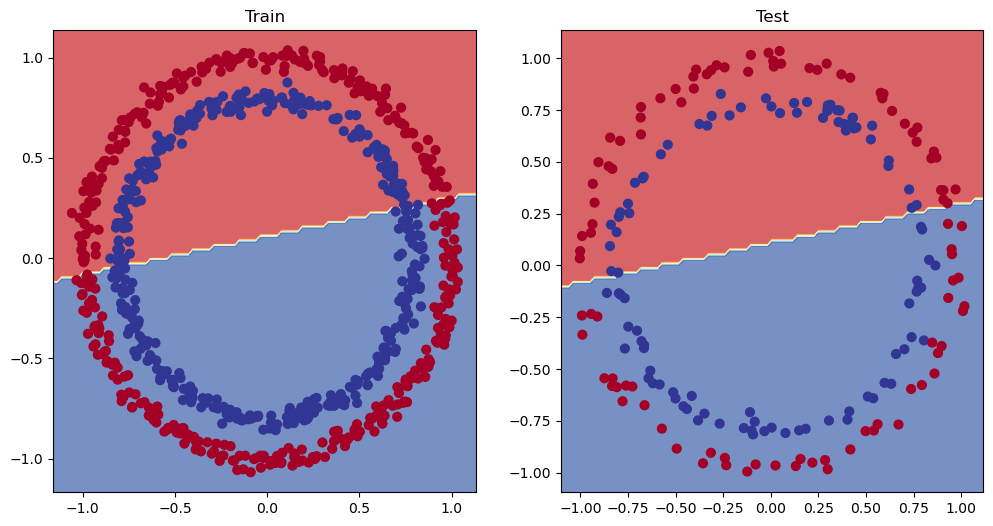

In [30]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model persepective)

* Add more layer
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the load function

These are model improvement, another method is through data.

Trying to improve the model by:
1. Increasing the layers from 2 -> 3
2. Increasing the hidden units from 5 -> 10
3. Increasing the epoch from 100 -> 1000

In [31]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
        # Start layering
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # Has speed up as there is no assignment

    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [33]:
# Set seeds
torch.manual_seed(42)
if device == 'mps':
   torch.mps.manual_seed(42)
elif device == 'cuda':
   torch.cuda.manual_seed(42)

# Create a training loop
epochs = 1000

# Put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
   # 1. Set model to train
   model_1.train()

   # 2. Forward pass
   y_logits = model_1(X_train).squeeze()
   y_pred = torch.round(torch.sigmoid(y_logits)) # model logits -> pred probs -> pred labels

   # 3. Calculate loss/acc
   loss = loss_fn(y_logits, 
                  y_train)
   acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
   
   # 4. Optimizer zero grad
   optimizer.zero_grad()

   # 5. Loss Backwards (back propagation)
   loss.backward()

   # 6. Optimizer Step
   optimizer.step()

   # 7. Test - Evaluate loss and acc
   model_1.eval()
   with torch.inference_mode():
      # Forward pass
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      # Calculate the loss/acc
      test_loss = loss_fn(test_logits,
                          y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

   # Print out logs
   if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss : {test_loss:.5f} | Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss : 0.69261 | Test Acc: 51.00%
Epoch: 100 | Loss: 0.69369 | Acc: 50.25% | Test Loss : 0.69269 | Test Acc: 50.00%
Epoch: 200 | Loss: 0.69351 | Acc: 50.12% | Test Loss : 0.69282 | Test Acc: 49.50%
Epoch: 300 | Loss: 0.69339 | Acc: 50.50% | Test Loss : 0.69295 | Test Acc: 49.00%
Epoch: 400 | Loss: 0.69329 | Acc: 50.38% | Test Loss : 0.69309 | Test Acc: 48.50%
Epoch: 500 | Loss: 0.69322 | Acc: 49.88% | Test Loss : 0.69322 | Test Acc: 49.50%
Epoch: 600 | Loss: 0.69317 | Acc: 49.50% | Test Loss : 0.69335 | Test Acc: 53.00%
Epoch: 700 | Loss: 0.69313 | Acc: 49.38% | Test Loss : 0.69347 | Test Acc: 50.50%
Epoch: 800 | Loss: 0.69309 | Acc: 50.00% | Test Loss : 0.69358 | Test Acc: 51.00%
Epoch: 900 | Loss: 0.69307 | Acc: 50.62% | Test Loss : 0.69368 | Test Acc: 47.50%


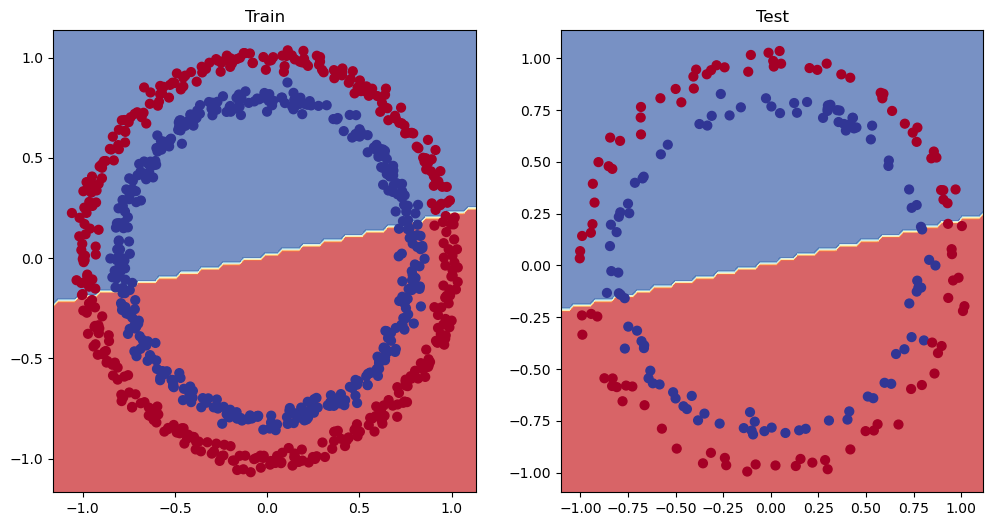

In [34]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing to see if our mode can fit a straight line

Troubleshoot a larger problem is to test it on a smaller problem

In [35]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression without epsilon

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [36]:
# Create training and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the length of the data
len(X_test_regression), len(X_train_regression), len(y_test_regression), len(y_train_regression)

(20, 80, 20, 80)

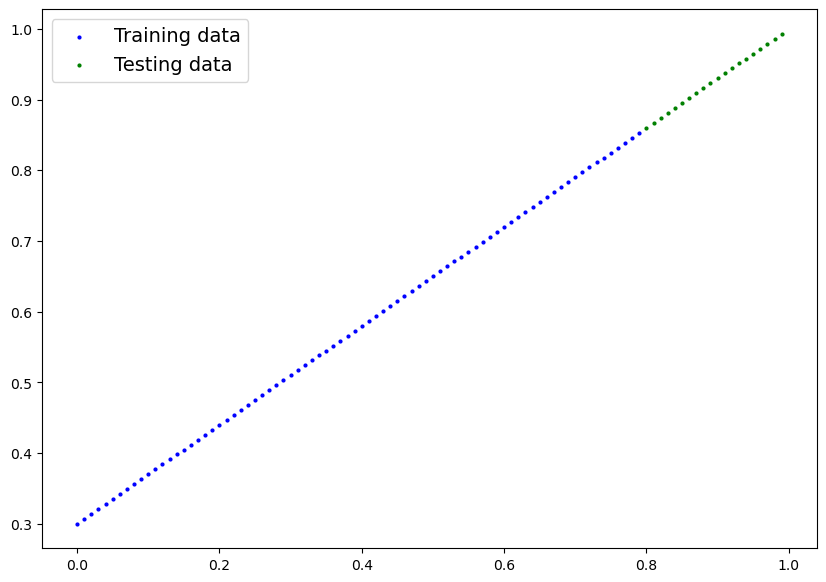

In [37]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [38]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
   nn.Linear(in_features=1,out_features=10),
   nn.Linear(in_features=10,out_features=10),
   nn.Linear(in_features=10,out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [40]:
# Train the model
# Set the seeds
torch.manual_seed(42)
if device=='mps':
   torch.mps.manual_seed(42)
elif device=='cuda':
   torch.cuda.manual_seed(42)

# Set epochs
epochs = 1000

# Put the data on the target device
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)

# Epoch training
for epoch in range(epochs):
   # Set model to train
   model_2.train()

   # Forward pass
   y_pred = model_2(X_train_regression)

   # Evaluate loss/acc
   loss = loss_fn(y_pred, y_train_regression)

   # optimizer grad zero
   optimizer.zero_grad()

   # Loss backwards
   loss.backward()

   # Optimizer step
   optimizer.step()
   
   # Testing
   model_2.eval()
   with torch.inference_mode():
      test_pred = model_2(X_test_regression)
      test_loss = loss_fn(test_pred, y_test_regression)
   
   # Print out training logs
   if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


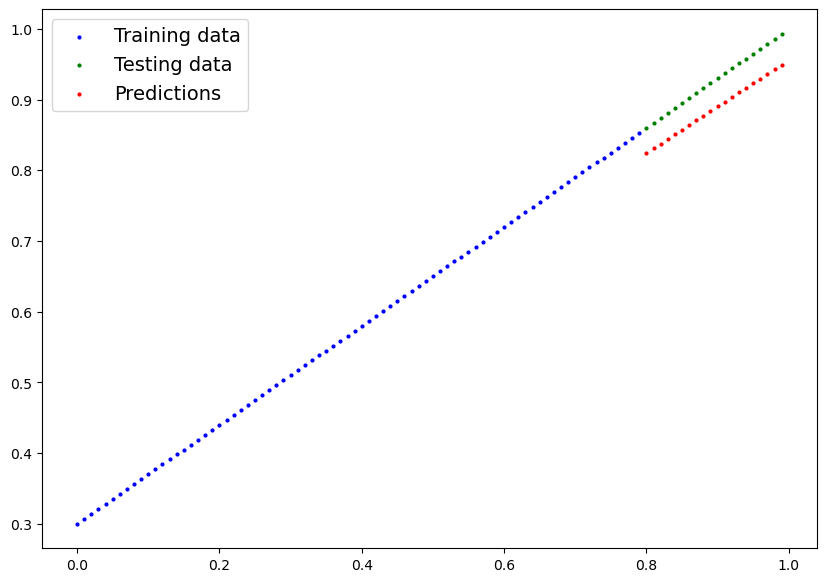

In [41]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu()
)

## 6.1 The missing piece: non-linearity



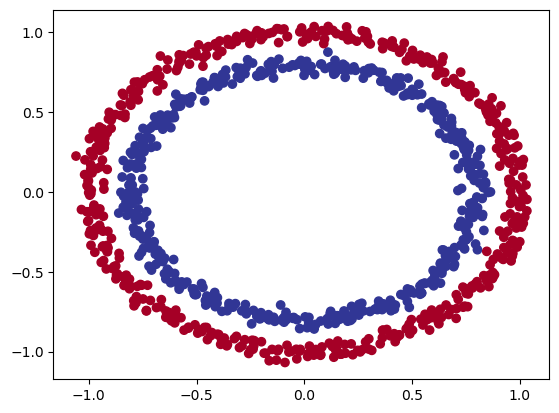

In [42]:
### 6.1 Recreating non-linear data (red and blue circles)
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [43]:
# Convert data to tensors
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Spilt into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a moidel with non-linearity

* Linear = straight linear
* Non-Linear = non-straight lines

In [44]:
# Build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
   def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(in_features=2, out_features=10)
      self.layer_2 = nn.Linear(in_features=10, out_features=10)
      self.layer_3 = nn.Linear(in_features=10, out_features=1)
      self.relu = nn.ReLU() # relu is a a non-linear activation function

   def forward(self,x):
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
# Set loss function
loss_fn = nn.BCEWithLogitsLoss()

# Set optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [46]:
# Training the model
# Set the random seed
torch.manual_seed(42)
if device == "mps":
   torch.mps.manual_seed(42)
elif device == "cude":
   torch.cuda.manual_seed(42)

# Put all data on target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Set epochs
epochs = 2000

# Training loop
for epoch in range(epochs):
   # Set model to train
   model_3.train()

   # Forward pass
   y_logits = model_3(X_train).squeeze()
   y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels
   
   # Calculate the loss and acc
   loss = loss_fn(y_logits, # BCE with logits loss takes in logits as first input
                  y_train)
   acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
   
   # Set zero grad
   optimizer.zero_grad()

   # Set backwards
   loss.backward()

   # optimizer step
   optimizer.step()

   ## Testing the model
   model_3.eval()
   with torch.inference_mode():
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      # Calculate loss and accuracy
      test_loss = loss_fn(test_logits,
                          y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
   

   # Print training loops log
   if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test loss: 0.69319 | Test acc: 50.00%
Epoch: 100 | Loss: 0.69115 | Acc: 52.88% | Test loss: 0.69102 | Test acc: 52.50%
Epoch: 200 | Loss: 0.68977 | Acc: 53.37% | Test loss: 0.68940 | Test acc: 55.00%
Epoch: 300 | Loss: 0.68795 | Acc: 53.00% | Test loss: 0.68723 | Test acc: 56.00%
Epoch: 400 | Loss: 0.68517 | Acc: 52.75% | Test loss: 0.68411 | Test acc: 56.50%
Epoch: 500 | Loss: 0.68102 | Acc: 52.75% | Test loss: 0.67941 | Test acc: 56.50%
Epoch: 600 | Loss: 0.67515 | Acc: 54.50% | Test loss: 0.67285 | Test acc: 56.00%
Epoch: 700 | Loss: 0.66659 | Acc: 58.38% | Test loss: 0.66322 | Test acc: 59.00%
Epoch: 800 | Loss: 0.65160 | Acc: 64.00% | Test loss: 0.64757 | Test acc: 67.50%
Epoch: 900 | Loss: 0.62362 | Acc: 74.00% | Test loss: 0.62145 | Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818 | Acc: 87.75% | Test loss: 0.57378 | Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153 | Acc: 93.50% | Test loss: 0.49935 | Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056 

### 6.4 Evaluating a model trained with non-linear activation functions

In [47]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
   y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

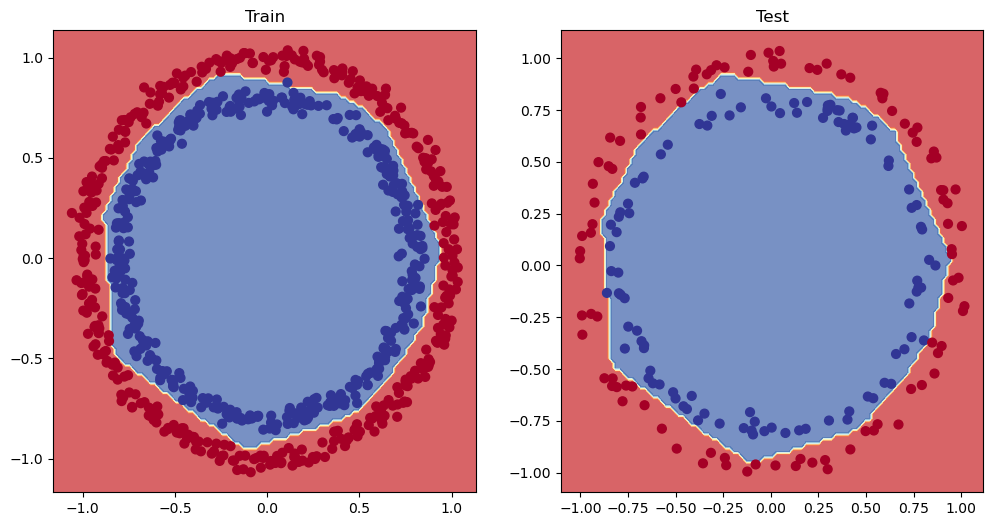

In [48]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


## 7. Replicating non-linear activation functions

Code linear and non-linear functions

In [49]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [50]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

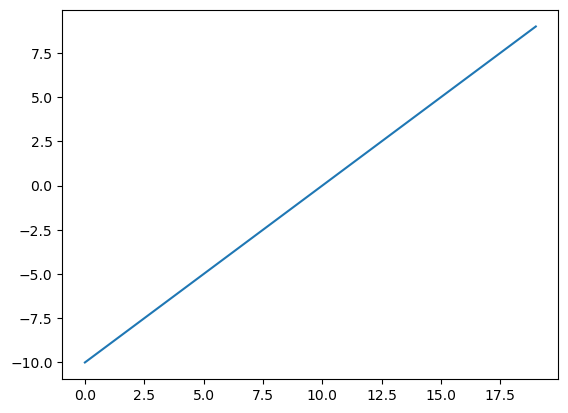

In [51]:
# Visualize the tensor
plt.plot(A)

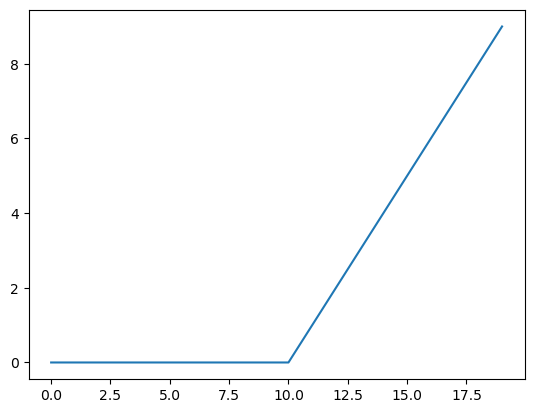

In [52]:
plt.plot(torch.relu(A))

In [53]:
def relu(x: torch.Tensor) -> torch.Tensor:
   return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

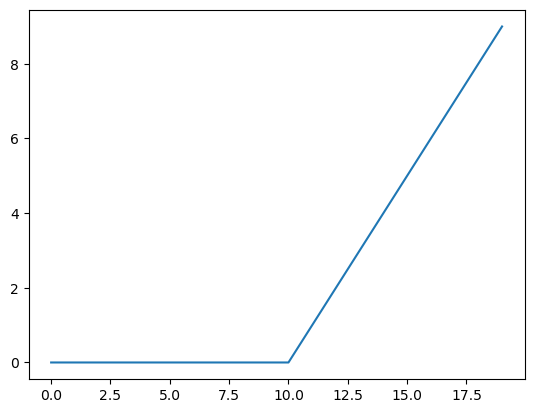

In [54]:
# Plot ReLU activation function
plt.plot(relu(A))

In [55]:
# Replicate sigmoid function
def sigmoid(x: torch.Tensor) -> torch.Tensor:
   return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

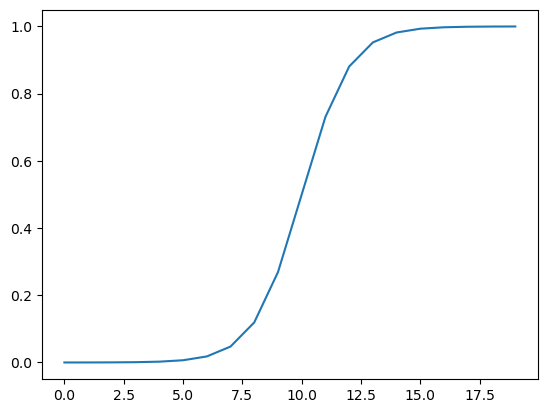

In [56]:
# Plot torch sigmoid
plt.plot(torch.sigmoid(A))

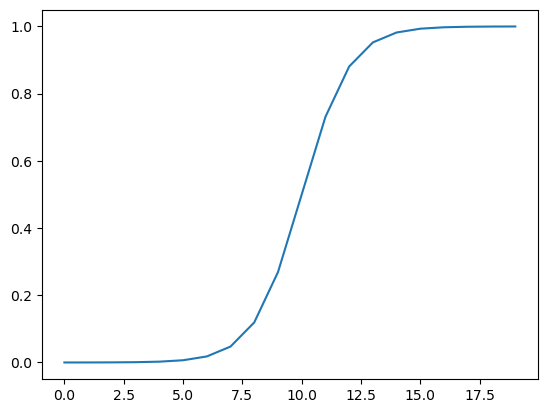

In [57]:
# Plot sigmoid function
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary Classification = one or the other
* Multi Classifcation = one of many labels

### 8.1 Creating a toy multi-class dataset

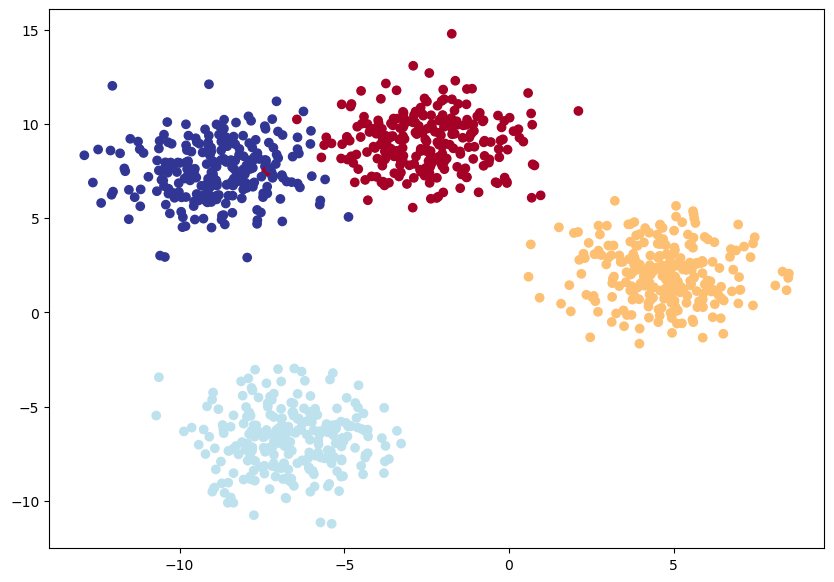

In [58]:
# Import Dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# SEt the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Spilt into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

### 8.2 Buildingg a multi-class classification model in Pytorch

In [59]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_avaliable() else "cpu"
device

'cuda'

In [60]:
# Build a multi-class classification model
class BlobModel(nn.Module):
   def __init__(self, input_features, output_features, hidden_units=8) -> None:
      """ Initializes multi-class classification model
      
      Args:
         input_features (int): Number of input features to the model
         outpuut_features (int): Number of output features (number of output classes)
         hidden units (int): Number of hidden units between layers, default 8
      """
      super().__init__()
      self.linear_layer_stack = nn.Sequential(
         nn.Linear(in_features=input_features, out_features=hidden_units),
         # nn.ReLU(),
         nn.Linear(in_features=hidden_units,out_features=hidden_units),
         # nn.ReLU(),
         nn.Linear(in_features=hidden_units,out_features=output_features)
      ) 

   def forward(self, x):
      return self.linear_layer_stack(x)
      
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for multiclass classification model

In [61]:
# Create a Loss function for multiclass classification model
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.01)

### 8.4 Getting prediction probabilities for a multi-classification model output

In order to evaluate and trian and test our model, we needs convert our model's outputs (logits) to prediction probability and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [62]:
# Showing raw outputs of model
model_4.eval()
with torch.inference_mode():
   y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')

In [63]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [64]:
# Convert model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:10])
print(y_pred_probs[:10])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951],
        [0.2788, 0.0088, 0.2893, 0.4232],
        [0.3246, 0.1261, 0.4545, 0.0948],
        [0.2229, 0.0443, 0.1867, 0.5461],
        [0.3447, 0.0368, 0.5269, 0.0917],
        [0.2145, 0.0510, 0.1752, 0.5593]], device='cuda:0')


In [65]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3], device='cuda:0')

In [66]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class classification Pytorch model

In [67]:
# Fit the multi-class model to the data
torch.manual_seed(42)
if device=="mps":
   torch.mps.manual_seed(42)
elif device=="cuda":
   torch.cuda.manual_seed(42)

# Set the epoch
epochs = 100

# Set data to device
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

# Training loop
for epoch in range(epochs):
   # Training
   model_4.train()

   # Forward pass
   y_logits = model_4(X_blob_train)
   y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
   
   # Create loss and accuracy
   loss = loss_fn(y_logits, y_blob_train)
   acc= accuracy_fn(
      y_true=y_blob_train,
      y_pred=y_preds
   )

   # Zero grad
   optimizer.zero_grad()

   # Backward (Back propagation)
   loss.backward()

   # Optimizer step
   optimizer.step()

   # Testing
   model_4.eval()
   with torch.inference_mode():
      test_logits = model_4(X_blob_test).squeeze()
      test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

      test_loss = loss_fn(test_logits,y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

   # Print training loop
   if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f} %")

Epoch: 0 | Loss: 1.04324 | Acc: 65.50% | Test Loss: 0.96335 | Test acc: 71.00 %
Epoch: 10 | Loss: 0.63688 | Acc: 79.50% | Test Loss: 0.61222 | Test acc: 88.00 %
Epoch: 20 | Loss: 0.46945 | Acc: 97.75% | Test Loss: 0.45865 | Test acc: 98.00 %
Epoch: 30 | Loss: 0.37339 | Acc: 98.50% | Test Loss: 0.36771 | Test acc: 99.00 %
Epoch: 40 | Loss: 0.31009 | Acc: 98.62% | Test Loss: 0.30659 | Test acc: 99.00 %
Epoch: 50 | Loss: 0.26486 | Acc: 98.88% | Test Loss: 0.26227 | Test acc: 99.00 %
Epoch: 60 | Loss: 0.23082 | Acc: 98.88% | Test Loss: 0.22853 | Test acc: 99.50 %
Epoch: 70 | Loss: 0.20429 | Acc: 99.12% | Test Loss: 0.20197 | Test acc: 99.50 %
Epoch: 80 | Loss: 0.18307 | Acc: 99.12% | Test Loss: 0.18057 | Test acc: 99.00 %
Epoch: 90 | Loss: 0.16578 | Acc: 99.12% | Test Loss: 0.16301 | Test acc: 99.00 %


### 8.6 Making and evaluating with a pytorch multi-class model

In [68]:
# Make predictions
model_4.eval()
with torch.inference_mode():
   y_logits = model_4(X_blob_test)

y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 0,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [69]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

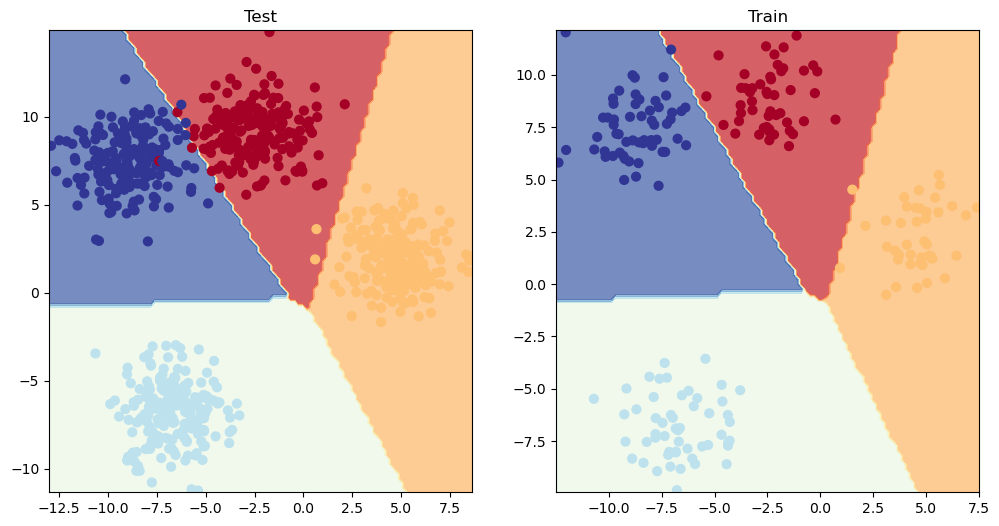

In [70]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - Out of 100 samples how many our model get right?
* Precision
* Recall
* F1-Score
* Confusion Matrix
* Classification report

In [77]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass",num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9900, device='cuda:0')